In [1]:
!pip install torchmetrics --quiet
import torch
from torchmetrics import F1Score
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF 
#from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import random
random.seed(7)
import umap
import seaborn as sns
import pandas as pd
%matplotlib inline

#load the embedding for trainset to make support set 
with open('../input/scotus-embedding/embeddingsSCOTUStrain.pickle', 'rb') as handle:
    embeddings_train = pickle.load(handle)
print(embeddings_train.keys())
#load the embedding for validationset to make query set
with open('../input/scotus-embedding/embeddingsSCOTUSvalidation.pickle', 'rb') as handle:
    embeddings_validation = pickle.load(handle)
print(embeddings_validation.keys())
# get the number of class
numberofclass = len(pd.unique(embeddings_train["lable"]))
print(numberofclass)

dict_keys(['embeddings_train', 'lable'])
dict_keys(['embeddings_validation', 'lable'])
13


In [2]:
def getF1score(y_true, y_pred):
    f1 = F1Score(average='micro')
    Ttrue_scores = torch.tensor(y_true)
    Ttrue_scores = Ttrue_scores.long()
    Tpredected_scores = torch.tensor(y_pred)
    fmicro =f1(Tpredected_scores, Ttrue_scores)
    f1 = F1Score(average='macro', num_classes= numberofclass)
    fmacro =f1(Tpredected_scores, Ttrue_scores)
    f1 = F1Score()
    f1s =f1(Tpredected_scores, Ttrue_scores)
    #fmicro=f1_score(y_true, y_pred, average='micro', zero_division=1)
    #fmacro=f1_score(y_true, y_pred, average='macro', zero_division=1)
    print("score micro is ", fmicro)
    print("score macro is ", fmacro)
    print("score F1 is ", f1s)
    return fmicro, fmacro, f1s

In [3]:
def getsupportset(k, seed):
    random.seed(seed)
    support_set=[]
    support_set_lable=[]
    print(k)
    for i in tqdm(range(numberofclass*k)):
        key =-1
        while key != i % numberofclass:
            ind = random.randint(0, len(embeddings_train["embeddings_train"])-1)
            key = embeddings_train["lable"][ind]
            if key == i % numberofclass:
                support_set_lable.append(key)
                #Compute cosine-similarities
                support_set.append(embeddings_train["embeddings_train"][ind])
    return support_set, support_set_lable

In [4]:
def plotConfusion_Matrix(y_true, y_pred, numberofclass, outputfile_name):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(numberofclass)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(range(numberofclass)))
    disp.plot()
    plt.savefig(outputfile_name+".png")
    plt.show()

In [5]:
def getoptimalk(support_set, support_set_lable, krange, unseen, e0, l0):
    Xf1_micro=[]
    Xf1_macro=[]
    for i in krange:
        y_true=[]
        y_pred=[]
        neigh = KNeighborsClassifier(n_neighbors=i,  weights="distance", metric="minkowski", p=1)
        #fit KNN in the suport set 
        neigh.fit(support_set, support_set_lable)
        # evaluate KNN in the trainin set (exclude lable 0 and lable 1) + support set 
        for j in range(len(e0)):
            if l0[j] not in unseen:
                y_true.append(l0[j])
                y_pred.append(neigh.predict([e0[j]])[0])
        fscor_micro=f1_score(y_true, y_pred, average='micro', zero_division=1)
        fscor_macro=f1_score(y_true, y_pred, average='macro', zero_division=1) 
        Xf1_micro.append(fscor_micro)
        Xf1_macro.append(fscor_macro)
    print(len(Xf1_micro))
    return max(Xf1_micro), Xf1_micro.index(max(Xf1_micro)), max(Xf1_macro), Xf1_macro.index(max(Xf1_macro))

In [6]:
def plot_resulta(resulta, bars, filename):
    #plt.plot(X,  unseen1Xmicrof1  , marker='D', linewidth=6)
    #bars = ('unseen 0', 'unseen 1','unseen  2', 'F1 micro', 'F1 macro')
    x_pos = np.arange(len(bars))
    # Create bars with different colors
    plt.bar(x_pos, resulta, color=[(0.2, 0.2, 0.2, 0.1),(0.2, 0.2, 0.2, 0.1), (0.3, 0.3, 0.3, 0.5), (0.3, 0.3, 0.3, 0.5)],  edgecolor='blue')
    # Create names on the x-axis
    plt.xticks(x_pos, bars)
    plt.ylabel('F1 score ')
    plt.savefig(filename+".png")
    # Show graph
    plt.show()

In [7]:
e0, l0 =getsupportset(30, 42)
x=np.arange(1,23)
f1s_KNN_micro=[]
koptim_KNN_micro=[]
f1s_KNN_macro=[]
koptim_KNN_macro=[]
for i in x:
    e, l =getsupportset(i, 7)
    k=x[2:min(i*13, 21)]
    f1_micro, k_index_micro, f1_macro, k_index_macro= getoptimalk(e, l, k, [0, 1], e0, l0)
    f1s_KNN_micro.append(f1_micro)
    koptim_KNN_micro.append(x[k_index_micro]+2)
    f1s_KNN_macro.append(f1_macro)
    koptim_KNN_macro.append(x[k_index_macro]+2)

30


  0%|          | 0/390 [00:00<?, ?it/s]

1


  0%|          | 0/13 [00:00<?, ?it/s]

11
2


  0%|          | 0/26 [00:00<?, ?it/s]

19
3


  0%|          | 0/39 [00:00<?, ?it/s]

19
4


  0%|          | 0/52 [00:00<?, ?it/s]

19
5


  0%|          | 0/65 [00:00<?, ?it/s]

19
6


  0%|          | 0/78 [00:00<?, ?it/s]

19
7


  0%|          | 0/91 [00:00<?, ?it/s]

19
8


  0%|          | 0/104 [00:00<?, ?it/s]

19
9


  0%|          | 0/117 [00:00<?, ?it/s]

19
10


  0%|          | 0/130 [00:00<?, ?it/s]

19
11


  0%|          | 0/143 [00:00<?, ?it/s]

19
12


  0%|          | 0/156 [00:00<?, ?it/s]

19
13


  0%|          | 0/169 [00:00<?, ?it/s]

19
14


  0%|          | 0/182 [00:00<?, ?it/s]

19
15


  0%|          | 0/195 [00:00<?, ?it/s]

19
16


  0%|          | 0/208 [00:00<?, ?it/s]

19
17


  0%|          | 0/221 [00:00<?, ?it/s]

19
18


  0%|          | 0/234 [00:00<?, ?it/s]

19
19


  0%|          | 0/247 [00:00<?, ?it/s]

19
20


  0%|          | 0/260 [00:00<?, ?it/s]

19
21


  0%|          | 0/273 [00:00<?, ?it/s]

19
22


  0%|          | 0/286 [00:00<?, ?it/s]

19


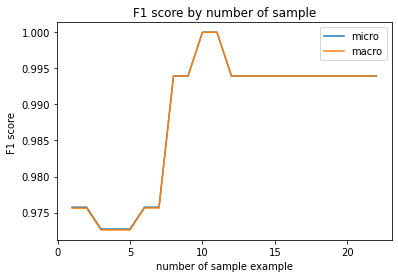

best k for FSL/micro 10
best k for KNN/micro 4
best k for FSL/macro 10
best k for KNN/micro 4


In [8]:
plt.plot(x, f1s_KNN_micro)
plt.plot(x, f1s_KNN_macro)
plt.title('F1 score by number of sample')
plt.ylabel('F1 score ')
plt.xlabel('number of sample example')
plt.legend(['micro', 'macro'], loc='upper right')
plt.show()
print("best k for FSL/micro", x[f1s_KNN_micro.index(max(f1s_KNN_micro))])
print("best k for KNN/micro", koptim_KNN_micro[f1s_KNN_micro.index(max(f1s_KNN_micro))]) 
print("best k for FSL/macro", x[f1s_KNN_macro.index(max(f1s_KNN_macro))])
print("best k for KNN/micro", koptim_KNN_macro[f1s_KNN_macro.index(max(f1s_KNN_macro))]) 

In [9]:
def gety_true_y_pred(e, l, k, nl=None, unseen=[], ev=embeddings_validation["embeddings_validation"], lv=embeddings_validation["lable"]):
        y_true=[]
        y_pred=[]
        neigh = KNeighborsClassifier(n_neighbors=k, weights="distance", metric="minkowski", p=1)
        neigh.fit(e, l)
        if nl==None:
            for j in range (len(ev)):
                if lv[j] not in unseen:
                    y_true.append(lv[j])
                    pred=neigh.predict([ev[j]])
                    y_pred.append(pred[0])
        else:
            for j in range (len(ev)):
                if lv[j]==nl:
                    y_true.append(lv[j])
                    pred=(neigh.predict([ev[j]]))
                    y_pred.append(pred[0])
        return y_true, y_pred

10 4
10


  0%|          | 0/130 [00:00<?, ?it/s]

score micro is  tensor(0.8944)
score macro is  tensor(0.0944)
score F1 is  tensor(0.8944)
score micro is  tensor(0.6514)
score macro is  tensor(0.0657)
score F1 is  tensor(0.6514)
score micro is  tensor(0.7193)
score macro is  tensor(0.6073)
score F1 is  tensor(0.7193)
[tensor(0.8944), tensor(0.6514), tensor(0.7193), tensor(0.6073)]


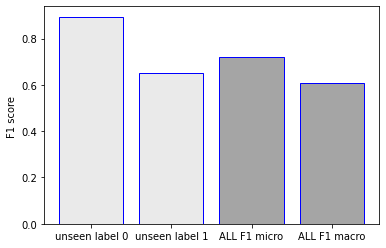

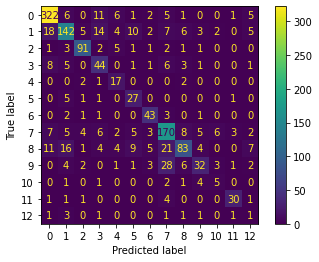

In [10]:
bestFSL_k =x[f1s_KNN_micro.index(max(f1s_KNN_micro))]
bestKNN_k =koptim_KNN_micro[f1s_KNN_micro.index(max(f1s_KNN_micro))]
#bestFSL_k =x[f1s_KNN_macro.index(max(f1s_KNN_macro))]
#bestKNN_k =koptim_KNN_macro[f1s_KNN_macro.index(max(f1s_KNN_macro))]
print(bestFSL_k, bestKNN_k)
e, l = getsupportset(bestFSL_k, 7)
result_KNN=[]
#unseen label 0
y_true_KNN, y_pred_KNN = gety_true_y_pred(e, l, bestKNN_k, 0)
f1microKNN, f1macroknn, _ =getF1score(y_true_KNN, y_pred_KNN)
result_KNN.append(f1microKNN)
#unseen label 1
y_true_KNN, y_pred_KNN = gety_true_y_pred(e, l, bestKNN_k, 1)
f1microKNN, f1macroknn, _ =getF1score(y_true_KNN, y_pred_KNN)
result_KNN.append(f1microKNN)
#all label
y_true_KNN, y_pred_KNN = gety_true_y_pred(e, l, bestKNN_k)
f1microKNN , f1macroknn, _ =getF1score(y_true_KNN, y_pred_KNN)
result_KNN.append(f1microKNN)
result_KNN.append(f1macroknn)
print(result_KNN)
bars = ('unseen label 0', 'unseen label 1', 'ALL F1 micro', 'ALL F1 macro')
plot_resulta(result_KNN, bars, "SCOTUS_keybert_knn")
plotConfusion_Matrix(y_true_KNN, y_pred_KNN, numberofclass, "CMscotus_keybert_knn")

In [11]:
def getSVMf1(X, y, unseenlable, e0, l0):
    #SVC(gamma=2, C=1)
    y_pred=[]
    y_true=[]
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X, y)
    for j in range(len(e0)):
        if l0[j] not in unseenlable:
            y_true.append(l0[j])
            pred=(clf.predict([e0[j]]))
            y_pred.append(pred[0])
    fscor_micro=f1_score(y_true, y_pred, average='micro', zero_division=1) 
    fscor_macro=f1_score(y_true, y_pred, average='macro', zero_division=1)
    return fscor_micro, fscor_macro

40


  0%|          | 0/520 [00:00<?, ?it/s]

1


  0%|          | 0/13 [00:00<?, ?it/s]

2


  0%|          | 0/26 [00:00<?, ?it/s]

3


  0%|          | 0/39 [00:00<?, ?it/s]

5


  0%|          | 0/65 [00:00<?, ?it/s]

7


  0%|          | 0/91 [00:00<?, ?it/s]

11


  0%|          | 0/143 [00:00<?, ?it/s]

13


  0%|          | 0/169 [00:00<?, ?it/s]

17


  0%|          | 0/221 [00:00<?, ?it/s]

19


  0%|          | 0/247 [00:00<?, ?it/s]

23


  0%|          | 0/299 [00:00<?, ?it/s]

29


  0%|          | 0/377 [00:00<?, ?it/s]

31


  0%|          | 0/403 [00:00<?, ?it/s]

37


  0%|          | 0/481 [00:00<?, ?it/s]

41


  0%|          | 0/533 [00:00<?, ?it/s]

43


  0%|          | 0/559 [00:00<?, ?it/s]

47


  0%|          | 0/611 [00:00<?, ?it/s]

53


  0%|          | 0/689 [00:00<?, ?it/s]

59


  0%|          | 0/767 [00:00<?, ?it/s]

61


  0%|          | 0/793 [00:00<?, ?it/s]

67


  0%|          | 0/871 [00:00<?, ?it/s]

71


  0%|          | 0/923 [00:00<?, ?it/s]

73


  0%|          | 0/949 [00:00<?, ?it/s]

79


  0%|          | 0/1027 [00:00<?, ?it/s]

83


  0%|          | 0/1079 [00:00<?, ?it/s]

89


  0%|          | 0/1157 [00:00<?, ?it/s]

97


  0%|          | 0/1261 [00:00<?, ?it/s]

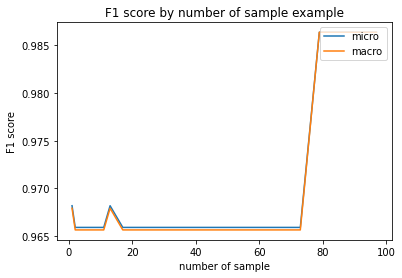

bset k for FSL micro 79
bset k for FSL macro  79


In [12]:
x=[1, 2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
f1s_SVM_micro=[]
f1s_SVM_macro=[]
e0, l0 =getsupportset(40, 42)
for i in x:
    e, l =getsupportset(i, 7)
    f1micro, f1macro= getSVMf1(e, l, [0, 1], e0, l0)
    f1s_SVM_micro.append(f1micro)
    f1s_SVM_macro.append(f1macro)
plt.plot(x, f1s_SVM_micro)
plt.plot(x, f1s_SVM_macro)
plt.title('F1 score by number of sample example')
plt.ylabel('F1 score')
plt.xlabel('number of sample')
plt.legend(['micro', 'macro'], loc='upper right')
plt.show()
#print("index best f1 micro", f1s_SVM_micro.index(max(f1s_SVM_micro)))
#print("best f1 micro", max(f1s_SVM_micro))
print("bset k for FSL micro", x[f1s_SVM_micro.index(max(f1s_SVM_micro))])

#print("index best f1 macro",f1s_SVM_macro.index(max(f1s_SVM_macro)))
#print("best f1 macro", max(f1s_SVM_macro))
print("bset k for FSL macro ", x[f1s_SVM_macro.index(max(f1s_SVM_macro))])


In [13]:
def getSVMy_truey_pred(e, l, nl=None, unseen=[]):
        y_true=[]
        y_pred=[]
        #SVC(gamma=2, C=1)
        neigh = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        neigh.fit(e, l)
        if nl==None:
            for j in range (len(embeddings_validation["embeddings_validation"])):
                if embeddings_validation["lable"][j] not in unseen:
                    y_true.append(embeddings_validation["lable"][j])
                    pred=neigh.predict([embeddings_validation["embeddings_validation"][j]])
                    y_pred.append(pred[0])
        else:
            for j in range (len(embeddings_validation["embeddings_validation"])):
                if embeddings_validation["lable"][j]==nl:
                    y_true.append(embeddings_validation["lable"][j])
                    pred=(neigh.predict([embeddings_validation["embeddings_validation"][j]]))
                    y_pred.append(pred[0])
        return y_true, y_pred

best_k_svm = x[f1s_SVM_micro.index(max(f1s_SVM_micro))]
#best_k_svm = x[f1s_SVM_macro.index(max(f1s_SVM_macro))]

79


  0%|          | 0/1027 [00:00<?, ?it/s]

score micro is  tensor(0.8806)
score macro is  tensor(0.1041)
score F1 is  tensor(0.8806)
score micro is  tensor(0.7294)
score macro is  tensor(0.0767)
score F1 is  tensor(0.7294)
score micro is  tensor(0.7236)
score macro is  tensor(0.6259)
score F1 is  tensor(0.7236)
[tensor(0.8806), tensor(0.7294), tensor(0.7236), tensor(0.6259)]


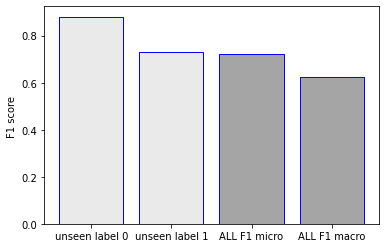

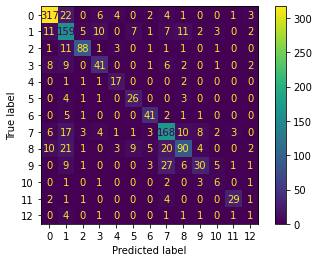

In [14]:
e, l =getsupportset(best_k_svm, 7)
result_svm=[]
#unseen lable 0
y_true_svm, y_pred_svm =getSVMy_truey_pred(e, l, 0)
f1microsvm, f1macrosvm, _ =getF1score(y_true_svm, y_pred_svm)
result_svm.append(f1microsvm)
#unseen lable 1
y_true_svm, y_pred_svm =getSVMy_truey_pred(e, l, 1)
f1microsvm, f1macrosvm, _ =getF1score(y_true_svm, y_pred_svm)
result_svm.append(f1microsvm)
#all lable
y_true_svm, y_pred_svm =getSVMy_truey_pred(e, l, None)
f1microsvm, f1macrosvm, _ =getF1score(y_true_svm, y_pred_svm)
result_svm.append(f1microsvm)
result_svm.append(f1macrosvm)
print(result_svm)
plot_resulta(result_svm, bars, "SCOTUS_keybert_svm")
plotConfusion_Matrix(y_true_svm, y_pred_svm, numberofclass, "CMscotus_keybert_svm")

In [15]:
def getUMAPembedding(e, l):
    reducer = umap.UMAP(random_state=42)
    reducer.fit(e)
    embedding = reducer.transform(e)
    # Verify that the result of calling transform is
    # idenitical to accessing the embedding_ attribute
    assert(np.all(embedding == reducer.embedding_))
    embedding.shape
    plt.scatter(embedding[:, 0], embedding[:, 1], c=l, cmap='Spectral', s=50)
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(numberofclass+1))
    #plt.title('UMAP projection of the embedding words', fontsize=24);
    plt.savefig("UMAP_Embedding_SCOTUS_keybert.png")
    e0=[]
    for i in range(embedding.shape[0]):
        e0.append(embedding[i])  
    return e0, l

10


  0%|          | 0/130 [00:00<?, ?it/s]

([array([1.6145656, 4.0505404], dtype=float32),
  array([1.2868258, 3.400225 ], dtype=float32),
  array([ 29.226917, -12.173996], dtype=float32),
  array([ 7.7595124, 13.014236 ], dtype=float32),
  array([ 3.3875716, -3.8254585], dtype=float32),
  array([10.480199 , -1.4356893], dtype=float32),
  array([6.0016418, 6.642125 ], dtype=float32),
  array([17.922052, 10.150291], dtype=float32),
  array([-11.665401,  12.593762], dtype=float32),
  array([ 15.673634, -11.023495], dtype=float32),
  array([ 16.611874, -10.542893], dtype=float32),
  array([-0.7853825, 15.472001 ], dtype=float32),
  array([19.518515, 16.15338 ], dtype=float32),
  array([1.5000463, 3.9745483], dtype=float32),
  array([1.657094 , 2.7848206], dtype=float32),
  array([ 29.670057, -11.777425], dtype=float32),
  array([ 7.784119, 13.122188], dtype=float32),
  array([ 3.5303438, -3.400379 ], dtype=float32),
  array([10.673607 , -1.5129303], dtype=float32),
  array([5.9818535, 6.6224704], dtype=float32),
  array([18.140545

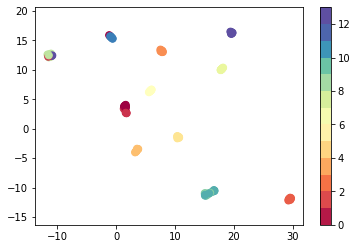

In [16]:
e, l = getsupportset(10, 7)
getUMAPembedding(e, l)